In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import anndata as ad

# raw hPSC organoids
org = pd.read_csv('data/hPSC_fetal_lung_org_counts.csv', index_col=0).T
org = ad.AnnData(org)
scv.pp.remove_duplicate_cells(org)
org.obs['cell_type'] = 'hPSC organoids'
org.obs['batch'] = 'hPSC organoids'

# raw hPSC fetal lung counts
S3 = pd.read_csv('data/hPSC_fetal_lung_cells_counts.csv', index_col=0).T
S3 = ad.AnnData(S3)
scv.pp.remove_duplicate_cells(S3)
S3.obs['cell_type'] = 'hPSC fetal lung cells'
S3.obs['batch'] = 'hPSC fetal lung cells'

In [2]:
sc.pp.filter_genes(S3, min_cells=30)
sc.pp.normalize_total(S3)
sc.pp.log1p(S3)
sc.pp.filter_genes(S3, min_cells=30)
sc.pp.normalize_total(org)
sc.pp.log1p(org)

In [3]:
sc.pp.highly_variable_genes(S3, n_top_genes = 3000, flavor='cell_ranger', batch_key='batch', subset=False)
sc.pp.highly_variable_genes(org, n_top_genes = 3000, flavor='cell_ranger', batch_key='batch', subset=False)

In [4]:
sc.pp.pca(S3)
sc.pp.pca(org)

In [5]:
sc.pp.neighbors(S3, n_neighbors=15, n_pcs=30)
sc.pp.neighbors(org, n_neighbors=15, n_pcs=30)

In [6]:
sc.tl.louvain(S3, resolution=0.15)
sc.tl.louvain(org, resolution=0.25)

In [7]:
sc.tl.umap(S3)
sc.tl.umap(org)

saving figure to file figures/hPSC_fetal_lung_umap.pdf


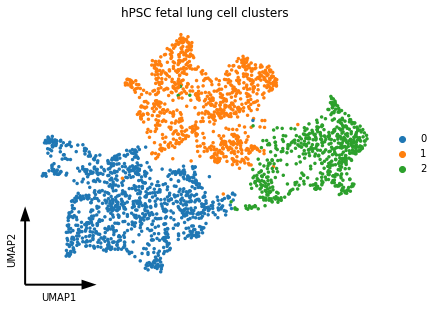

saving figure to file figures/hPSC_organoids_umap.pdf


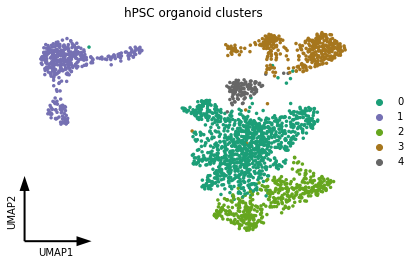

In [8]:
# plot UMAPs with clusters
scv.pl.umap(S3, color='louvain', frameon='artist',
            title='hPSC fetal lung cell clusters', fontsize=12,
           legend_loc='right',
    save='figures/hPSC_fetal_lung_umap.pdf')

scv.pl.umap(org, color='louvain', frameon='artist',
            title='hPSC organoid clusters', fontsize=12,
           legend_loc='right', palette='Dark2',
    save='figures/hPSC_organoids_umap.pdf')

In [9]:
# compute DEG
sc.tl.rank_genes_groups(S3, groupby='louvain', method='wilcoxon')
sc.tl.rank_genes_groups(org, groupby='louvain', method='wilcoxon')

In [10]:
S3_groups = []
for group in S3.obs.louvain.unique():
    temp = sc.get.rank_genes_groups_df(S3, group=group)[:100]
    temp['louvain'] = group
    S3_groups.append(temp)
pd.concat(S3_groups).to_csv('data/hPSC_fetal_lung_DEG.csv')

org_groups = []
for group in org.obs.louvain.unique():
    temp = sc.get.rank_genes_groups_df(org, group=group)[:100]
    temp['louvain'] = group
    org_groups.append(temp)
pd.concat(org_groups).to_csv('data/hPSC_organoids_DEG.csv')

In [11]:
quach_degs = pd.read_excel('../Wong_Fetal_Lung_Dataset_August_2023.xlsx', 
                     sheet_name='Epithelial')

In [12]:
org.write('data/org_unintegrated_clusters.h5ad')
S3.write('data/S3_unintegrated_clusters.h5ad')

In [13]:
marker_genes = {}
for deg in quach_degs.keys().values:
    marker_genes[deg] = list(quach_degs[deg][~quach_degs[deg].isnull()].values)

In [14]:
# marker DEG overlaps
S3_df = sc.tl.marker_gene_overlap(S3, reference_markers = marker_genes, 
                         method='overlap_coef')

In [15]:
org_df = sc.tl.marker_gene_overlap(org, reference_markers = marker_genes,
                         method='overlap_coef')

In [16]:
S3_df.to_csv('data/hPSC_fetal_lung_overlap.csv')
org_df.to_csv('data/hPSC_organoids_overlap.csv')

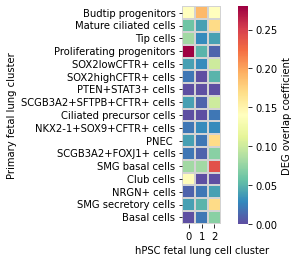

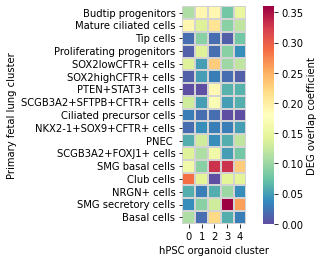

In [17]:
# plot marker DEGs. 
# remove stromal-like since they only have a small number of genes.

import seaborn as sns
import matplotlib.pyplot as plt

s = sns.heatmap(S3_df.loc[~S3_df.index.isin(['Stromal-like cells 1', 'Stromal-like cells 2'])], 
            cmap='Spectral_r', linewidths=0.01, linecolor='#D3D3D3', square=True,
            cbar_kws={'label': 'DEG overlap coefficient'})
s.set(xlabel='hPSC fetal lung cell cluster', ylabel='Primary fetal lung cluster')
plt.savefig('figures/hPSC_fetal_lung_deg_overlap.pdf')
plt.show()

import seaborn as sns
s = sns.heatmap(org_df.loc[~org_df.index.isin(['Stromal-like cells 1', 'Stromal-like cells 2'])],
            cmap='Spectral_r', linewidths=0.01, linecolor='#D3D3D3', square=True, 
            cbar_kws={'label': 'DEG overlap coefficient'})
s.set(xlabel='hPSC organoid cluster', ylabel='Primary fetal lung cluster')
plt.savefig('figures/hPSC_organoids_deg_overlap.pdf')
plt.show()